# Isovolemic Constraints implemented in a SparkContext
Tim Tyree<br>
6.9.2020<br>

In [1]:
#pylab
# %matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
# from pylab import imshow, show

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# import skimage as sk
# from skimage import measure, filters

# import matplotlib.pyplot as plt, numpy as np, os
# from numba import njit, jit, vectorize
# from PIL import Image
# import imageio
# import cv2 as cv
#automate the boring stuff

from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    sys.path.append("../lib") 
    sys.path.append("lib") 
from operari import *
from ProgressBar import *
from mesh_ops import *

# the visualization tools involved here for triangular meshes is
import trimesh
import pyglet
# from numba import njit

# from pyspark import SparkContext
# sc = SparkContext(master="local[4]")
# print(sc)


%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


#  import mesh of right atrium

In [4]:
assert(os.path.exists('Data/patient85_RA_closed.stl'))
mesh = trimesh.load('Data/patient85_RA_closed.stl')

In [73]:
mesh.volume

26270.108866430666

In [466]:
def get_A(vid):
    q = np.array(mesh.vertices[vid])
    N1q = np.array(mesh.vertices[mesh.vertex_neighbors[vid]])
    return calc_area(q,N1q)
# @njit
def calc_area(q, N1q):
    '''compute A_star'''
#     d_lst = N1q - q
    q_degree = len(N1q)
    q_A = 0. * q
    for i in range(q_degree - 1, -1, -1):
        q_A += np.cross( N1q[i] - N1q[i-1], N1q[i])
    q_A /= (2 * 3)
    return q_A
def angle_between(v1,v2): 
    return np.arccos(np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*180/np.pi

# some basic operations for a vertex

In [437]:
#star function for a vertex
vf = mesh.vertex_faces[0]
mesh.faces[vf[vf>-1]]

TrackedArray([[  0, 336, 639],
              [  0, 639, 545],
              [734, 336,   0],
              [543,   0, 545],
              [641, 734,   0],
              [641,   0, 543]])

In [438]:
vid = 53
angle = angle_between(get_A(vid),mesh.vertex_normals[vid])#np.arccos(np.dot(q_A,mesh.vertex_normals[vid])/np.linalg.norm(q_A))*180/np.pi
# angle = angle_between(q_A,mesh.vertex_normals[vid])#np.arccos(np.dot(q_A,mesh.vertex_normals[vid])/np.linalg.norm(q_A))*180/np.pi
print(f'the mean neighboring normal forms an angle with this vertex area vector that is {angle:.1f} degrees.')

the mean neighboring normal forms an angle with this vertex area vector that is 64.5 degrees.


# the total the surface area of the mesh is greater than the sum of the area vectors I assign to each vertex.

In [439]:
A_array = 0.*mesh.vertices.copy()
for vid,q in enumerate(mesh.vertices):
    N1q = np.array(mesh.vertices[mesh.vertex_neighbors[vid]])
    A_array[vid] = calc_area(q, N1q)

In [440]:
surface_area = 0.
for A in A_array:
    surface_area += np.linalg.norm(A)
surface_area /= 3

In [441]:
surface_area

585.8444350405415

In [442]:
mesh.area

4600.3452390565935

# Why didn't this work: compute the total volume of the mesh by my method and compare

In [181]:
#compute the signed volume of a single face for q0=0

In [443]:
#this is done in linear time.  reduce can do it in logarithmic time
q0 = mesh.center_mass
vstar = 0.
for vid,q in enumerate(mesh.vertices):
    vstar += np.dot(-get_A(vid),q-q0)

In [444]:
vstar

1989.7767763465715

In [446]:
mesh.volume

-13074.559676291243

# sum individual faces, see if that works

In [255]:
mesh.vertices

TrackedArray([[  35.59590912, -103.31027222,  233.38258362],
              [  28.8176384 ,  -98.76280212,  204.75924683],
              [  30.63431168,  -90.4643631 ,  230.48248291],
              ...,
              [  42.07120895,  -94.86171722,  214.14703369],
              [  30.08992767, -117.21230316,  242.42103577],
              [  27.95349503, -106.69200134,  205.28355408]])

In [256]:
mesh.faces

TrackedArray([[ 188,   37, 1195],
              [  37,  670, 1195],
              [  37,  179,  670],
              ...,
              [1116, 1406, 1137],
              [1116,  319, 1406],
              [1116,  327,  319]])

In [257]:
#this is the area vector of the face in position zero
mesh.area_faces[0]*mesh.face_normals[0]

array([ 0.10289507, -0.55941712,  0.22833886])

In [258]:
#I reproduced ^that area vector for the face in the zeroth position
q = np.array(mesh.vertices[vid])
N1q = np.array(mesh.vertices[mesh.vertex_neighbors[vid]])
abc = mesh.vertices[mesh.faces[0]]
np.cross(abc[1]-abc[0],abc[2]-abc[0])/2 - mesh.area_faces[0]*mesh.face_normals[0]

array([1.38777878e-17, 0.00000000e+00, 2.77555756e-17])

In [259]:
# q_A += np.cross(d_lst[i - 1], d_lst[i])

In [260]:
# todo: compute total volume by summing my volume for each face

In [263]:
vol = 0.
for k in range(mesh.faces.shape[0]):
    vol += np.dot(mesh.area_faces[k]*mesh.face_normals[k],mesh.vertices[mesh.faces[k]][0])
vol /= 3
print(vol)

26270.10886643064


In [265]:
mesh.volume

26270.108866430666

In [266]:
#I reproduced ^that the total volume 

# TODO? list: so next is either 
- TODO: figure out why my "A star" isn't giving me the right total volume or 
- TDOO: define a spring force between each pair of vertices

# plot "A star" at each vertex

In [68]:
x, y, z = mesh.vertices.T
astar_list = np.array([get_A(vid) for vid in range(mesh.vertices.shape[0])])
u, v, w = astar_list.T

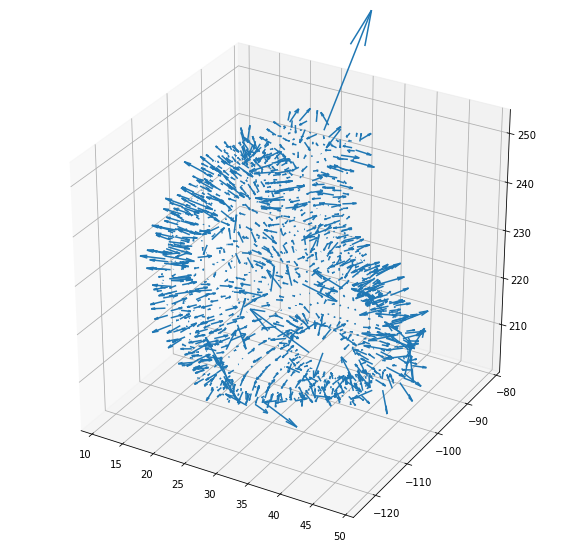

In [69]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.quiver(x, y, z, u, v, w, length=1, normalize=False)
plt.show()

In [323]:
as_magnitudes = [np.linalg.norm(v) for v in astar_list]

In [324]:
np.max(as_magnitudes)

23.459018250114173

In [325]:
np.mean(as_magnitudes)

1.4106191110049384

In [339]:
a = np.array(as_magnitudes)
a[a > 8]

array([ 8.09173277, 23.45901825, 22.60091903,  8.24134115])

In [348]:
huge_arrow_id = np.argwhere(a > 10).flatten()[0]

In [349]:
mesh.vertices[huge_arrow_id]

TrackedArray([  37.3569603 , -113.0272522 ,  219.39202881])

Text(0.5, 1.0, 'these are 54 neighbors of \nthe huge arrow at vertex id = 883')

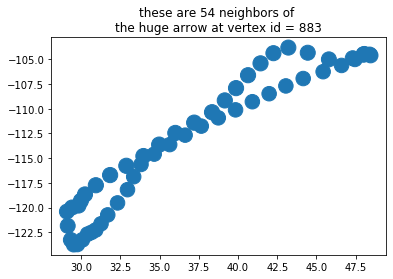

In [408]:
x, y, z = np.array(mesh.vertices[mesh.vertex_neighbors[huge_arrow_id]]).T
plt.scatter(x=x,y=y,s=z)
plt.title(f'these are {len(mesh.vertex_neighbors[huge_arrow_id])} neighbors of \nthe huge arrow at vertex id = {huge_arrow_id}')

In [366]:
s = mesh.vertices[huge_arrow_id] - np.array(mesh.vertices[mesh.vertex_neighbors[huge_arrow_id]])
mean_dist_to_neighbors = np.mean([np.linalg.norm(vs) for vs in s])

In [367]:
print(f'the mean distance the huge arrow is from its neighbor is  {mean_dist_to_neighbors:.1f}.')

the mean distance the huge arrow is from its neighbor is  12.6.


So 2 weird huge A star vectors likley correspond to two of the three caps that I put in with high connectivity/high degree/large number of neighbors.  They won't be updated when time stepping, they are static and thus will be ignored. 

This does mean that I cannot do time steps on the raw closed mesh since it doesn't distinguish the caps from the native vertices. so I must 

 - define spring forces with some equilibrium length and some spring constant
 - compute net force for a given vertex
 - define masses for each vertex

In [409]:
mesh.triangles_cross[0]/2

array([ 0.10289507, -0.55941712,  0.22833886])

In [410]:
mesh.area_faces[0]*mesh.face_normals[0]

array([ 0.10289507, -0.55941712,  0.22833886])

In [411]:
mesh.mass_properties

{'density': 1.0,
 'mass': 26270.108866430666,
 'volume': 26270.108866430666,
 'center_mass': array([  27.33454252, -102.45310067,  224.67990682]),
 'inertia': array([[5432435.68390131,   88717.40368387, -772831.88656226],
        [  88717.40368387, 4742547.95358634, -283400.64839864],
        [-772831.88656226, -283400.64839864, 3239778.79332942]])}

In [162]:
# import openpyscad as ops
# i = ops.Difference()
# i.append(mesh)
# i.append(caps)

# import shapely

In [161]:
# mesh.difference(caps, engine = 'scad')
# engine (str) – Which backend to use, i.e. ‘blender’ or ‘scad’


In [159]:
# #brute force computation of intersection that doesn't even work in the easiest bloody case.
# # tol = 1e-14
# match_lst = []
# for i1, t1 in enumerate(mesh.triangles):
#     for i2, t2 in enumerate(caps.triangles):
#         delta_t = t2 - t1
#         if np.isclose(delta_t,0., atol = 1e-3, rtol = 0.).all():
# #         if (delta_t == 0 ).all():
#             match_lst.append(i1)
# #             match_lst.append((i1,i2))
# #         sum_of_differences = np.add.reduce(delta_t.flatten())
# #         if sum_of_differences<tol:
# #             match_lst.append((i1,i2))

# cap_test.show()
# caps.show()

# efficiently find vertices that are/are not touching a cap

In [501]:
# caps = trimesh.load('Data/patient85_RA_caps.ply')
mesh_closed = trimesh.load('Data/patient85_RA_closed.ply')
df = pd.read_csv('Data/patient85_RA_vertices.csv',index_col = 0)
vertex_indices_of_not_caps = list(df.query('group == -1').index)
vertex_indices_of_caps = list(df.query('group > -1').index)

In [366]:
mesh_open = mesh_closed.submesh((vertex_indices_of_not_caps,), append=True)
mesh_caps = mesh_closed.submesh((vertex_indices_of_caps,), append=True)

In [502]:
mesh_closed.show()

# TODO: translate vertex_indices_of_not_caps to triangle_indices_of_not_caps simply

In [363]:
vid = vertex_indices_of_non_caps[0]

In [383]:
# lst_vf = []
# for vid in vertex_indices_of_non_caps:
#     svf = set(mesh.vertex_faces[vid])
#     lst_vf.extend(svf)

In [395]:
# mesh = mesh_closed.copy()
# mesh = mesh_open.copy()

In [447]:
vert = np.loadtxt('Data/pt85_RA_vert')
faces = np.loadtxt('Data/pt85_RA_faces')
faces = faces - 1 #fix: 1 to 0 indexing
mesh = trimesh.Trimesh(vertices=vert,
                       faces=faces)
vertices = mesh.vertices.view(np.ndarray)

# Calculate spring forces for some extension and spring constant for a single vertex 

In [448]:
from numba import njit
@njit
def spring_force(x, x0, k):
    '''general spring force in the direction of x with magnitude k*(np.linalg.norm(x) - x0).
    k and x0 are floats. x is a vector.'''
    absx = np.linalg.norm(x)
    dx = absx-x0
    return k*dx*x/absx

In [449]:
x, y, z = mesh.vertices.T
astar_list = np.array([get_A(vid) for vid in range(mesh.vertices.shape[0])])
# m.area_faces[vid]*mesh.face_normals[vid] this is A for one face, and it is faster
u, v, w = astar_list.T

In [451]:
# vid = 52
# N1q      = mesh.vertex_neighbors[vid]
# q        = vertices[vid]
# F_lst = []
# F_net = np.array([0.,0.,0.])
# for nid in N1q:
#     qi = vertices[nid]
#     Fi = spring_force(x=qi-q, x0=1, k=1)
#     F_lst.append(Fi)
#     F_net += Fi

In [410]:
# np.add.reduce(np.array(F_lst))

In [411]:
# F_net

# TODO: compute the length of each edge. store in a df['x_init']
#AND THEN compute a resting length x0 for each edge

In [453]:
# vid = 52
# vertices = mesh.vertices.view(np.ndarray)
# N1q      = mesh.vertex_neighbors[vid]
# q        = vertices[vid]
# F_lst = []
# F_net = np.array([0.,0.,0.])
# for nid in N1q:
#     qi = vertices[nid]
#     Fi = spring_force(x=qi-q, x0=1, k=1)
#     F_lst.append(Fi)
#     F_net += Fi

In [454]:
df = pd.DataFrame(mesh.edges, columns = ['a','b']).astype('int')
x_init_lst = []
for b, a in mesh.edges:
    x_init_lst.append(np.linalg.norm(vertices[b] - vertices[a]))
df['x_init'] = x_init_lst

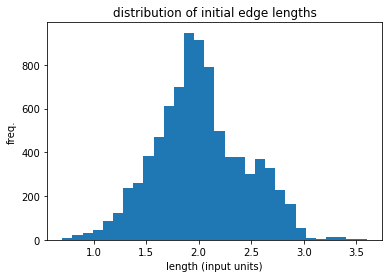

In [455]:
plt.hist(df.x_init.values, bins=30)
plt.title('distribution of initial edge lengths')
plt.ylabel('freq.')
plt.xlabel('length (input units)')
plt.show()

In [456]:
df.describe()['x_init'][['mean','std']]

mean    2.016235
std     0.428512
Name: x_init, dtype: float64

# assuming constant wall stress, assign a spring constant and equilibrium length to each edge

We have some force per unit length we can define as
$$
\gamma = \frac{k\Delta x}{x_0 + \Delta x}
$$
Initially, we have $x_\text{initial} = x_0 + \Delta x_\text{initial}$, so for each vertex, we can compute the lengths where the springs exert zero force to be

$$x_0 = (1 - \gamma/k)x_\text{initial}$$


In [457]:
df['gamma']  = 0.5
df['k']  = 1
df['x0'] = (1 - df['gamma']/df['k'])*df['x_init']

# for each vertex, compute the net_spring_forces by iterating over the edges

In [458]:
# this takes 2.8 seconds to compute the net forces on 806 rows.  Not ideal
net_spring_forces = 0.*vertices
for rowid, row in df.iterrows():
    b, a, k, x0 = row[['b','a','k','x0']]
    b = int(b); a = int(a)
    F = spring_force(x=vertices[b] - vertices[a],x0=x0,k=k)
    net_spring_forces[a] += F
    net_spring_forces[b] -= F

In [459]:
F_lst = []
for F in net_spring_forces:
    F_lst.append(np.linalg.norm(F))

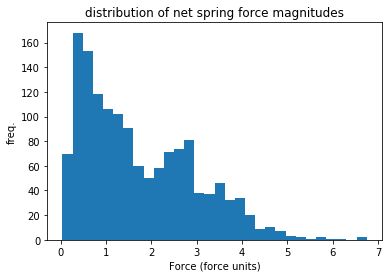

In [460]:
plt.hist(F_lst, bins=30)
plt.title('distribution of net spring force magnitudes')#\nfor $\gamma=0.5$ and $k=1$ force/length units')
plt.ylabel('freq.')
plt.xlabel('Force (force units)')
plt.show()

# compute the pressure forces on each vertex
- and then compute the distribution of angles between the net spring force and the net pressure force

In [491]:
#using my Astar method
P = 1. #the pressure difference between the inside and the outside of the mesh
pressure_forces = np.array([get_A(vid) for vid in range(mesh.vertices.shape[0])])
pressure_forces *= P
pressure_forces[0]

array([0.46278393, 0.10646554, 0.45808887])

In [494]:
# the mean normals of the faces the vertex is used in.
P = 1. #the pressure difference between the inside and the outside of the mesh
pressure_forces = np.array([mesh.vertex_normals[vid] for vid in range(mesh.vertices.shape[0])])
pressure_forces *= P


In [495]:
FP_lst = []
for F in pressure_forces:
    FP_lst.append(np.linalg.norm(F))

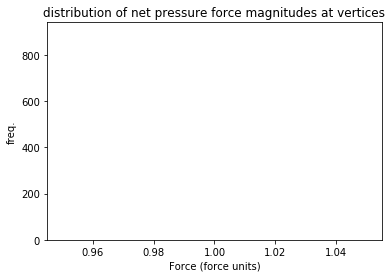

In [496]:
plt.hist(FP_lst, bins=30)
plt.title('distribution of net pressure force magnitudes at vertices')
plt.ylabel('freq.')
plt.xlabel('Force (force units)')
plt.show()

In [498]:
angle_lst = []
for v1,v2 in zip(pressure_forces,net_spring_forces):
    angle_lst.append(angle_between(v1,v2))
    

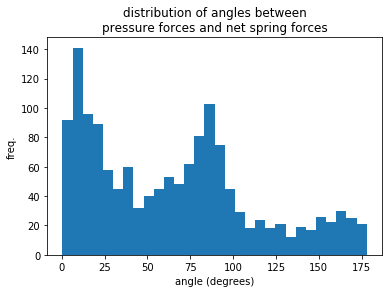

In [499]:
plt.hist(angle_lst, bins=30)
plt.title('distribution of angles between\npressure forces and net spring forces')
plt.ylabel('freq.')
plt.xlabel('angle (degrees)')
plt.show()

# Mayday Mayday Mayday!!! ^this histogram should (at equilibrium) have net spring forces poking in the opposite direction as pressure forces.

Steps to address:
- let the system evolve to equilibrium and see if they align or behave reasonably
- failing ^that try the curvature measures built in to trimesh.curvature (avoid reimplementing

# compute the net force on each vertex. visualize.  what do you have to do to minimize the net force on each vertex?

In [472]:
x, y, z = mesh.vertices.T
u, v, w    = pressure_forces.T
us, vs, ws = net_spring_forces.T

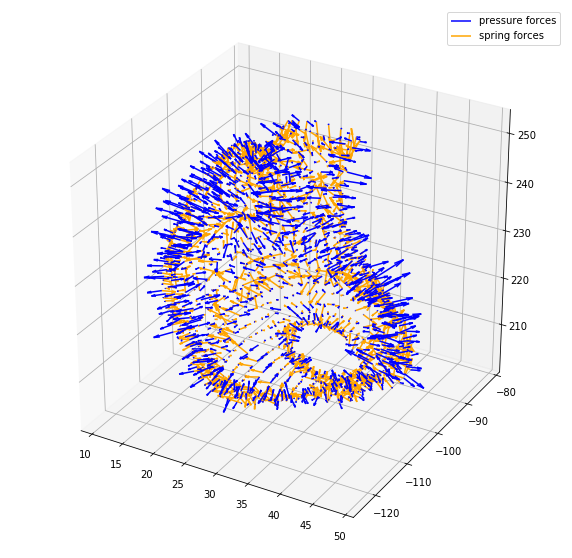

In [500]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.quiver(x, y, z, u, v, w, length=1, normalize=False, color='blue', label='pressure forces')
ax.quiver(x, y, z, us, vs, ws, length=1, normalize=False, color='orange', label='spring forces')
ax.legend()
plt.show()



# TODO: compute the classical curvature for every mesh point